In [1]:
%matplotlib inline
from pathlib import Path
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd

In [2]:
def load_indep_ars():
    df = pd.read_csv("./mgcx/marcc/indep_ars_result.csv")
    wildhsic_dat = pd.Series(
        loadmat('./wildBootstrap/power_curves/wildHSIC_powers_independent_ars.mat')['powers'][:, 1],
        name = 'wildHSIC_powers')
    wildhsic2_dat = pd.Series(
        loadmat('./wildBootstrap/power_curves/wildHSIC2_powers_independent_ars.mat')['powers'][:, 1],
        name = 'wildHSIC2_powers')
    shifthsic_dat = pd.Series(
        loadmat('./HSIC/power_curves/shiftHSIC_powers_independent_ars.mat')['powers'][:, 1],
        name = 'shiftHSIC_powers')

    df = pd.concat([df, wildhsic_dat, wildhsic2_dat, shifthsic_dat], axis=1)
    
    return df

def load_extinct_gaussian():
    df = pd.read_csv("./mgcx/marcc/extinction_rate_results.csv")
    wildhsic_dat = pd.Series(
        loadmat('./wildBootstrap/power_curves/wildHSIC_powers_extinct_gaussian.mat')['powers'][:, 1],
        name = 'wildHSIC_powers')
    wildhsic2_dat = pd.Series(
        loadmat('./wildBootstrap/power_curves/wildHSIC2_powers_extinct_gaussian.mat')['powers'][:, 1],
        name = 'wildHSIC2_powers')
    shifthsic_dat = pd.Series(
        loadmat('./HSIC/power_curves/shiftHSIC_powers_extinct_gaussian.mat')['powers'][:, 1],
        name = 'shiftHSIC_powers')

    df = pd.concat([df, wildhsic_dat, wildhsic2_dat, shifthsic_dat], axis=1)
    
    return df

def load_power_curves(
    processes = ["indep_ar1", "corr_ar1", "nonlin_lag1"]
):
    mgcx_power_dir = "./mgcx/powers"
    wildHSIC_power_dir = "./wildBootstrap/power_curves"
    shiftHSIC_power_dir = "./HSIC/power_curves"

    mgcx_power_path = Path(mgcx_power_dir)
    wildHSIC_power_path = Path(wildHSIC_power_dir)
    shiftHSIC_power_path = Path(shiftHSIC_power_dir)
    
    dfs = []
    for process in processes:
        n = np.arange(10, 201, 10)
        df = pd.DataFrame(n, columns = ['n'])
        process_series = pd.Series([process] * n.size, name = 'process')
        df = df.join(process_series, how='right')
        mgcx_power_files = sorted(mgcx_power_path.glob(f"*{process}*"))
        wildHSIC_power_files = sorted(wildHSIC_power_path.glob(f"wildHSIC_powers_{process}*"))
        wildHSIC2_power_files = sorted(wildHSIC_power_path.glob(f"wildHSIC2_powers_{process}*"))
        shiftHSIC_power_files = sorted(shiftHSIC_power_path.glob(f"*{process}*"))
        files = mgcx_power_files + wildHSIC_power_files + wildHSIC2_power_files + shiftHSIC_power_files
        
        for file in files:
            test_name = file.name.split("_")[0]
            if "pkl" in file.name:
                pickle_in = open(file,"rb")
                powers = pickle.load(pickle_in)[:, 1]
                pickle_in.close()
            elif "mat" in file.name:
                dat = loadmat(file)
                powers = dat['powers'][:, 1]
            
            to_append = pd.Series(powers, name=test_name)
            
            df = df.join(to_append, how='right')
        dfs.append(df)
            
    return pd.concat(dfs)

In [3]:
color_dict = dict(
    mgcx = "#e41a1c",
    dcorrx = "#984ea3",
    ljungx = "#377eb8",
    wildHSIC = "#4daf4a",
    wildHSIC2 = "#ff7f00",
    shiftHSIC = "#ffff33"
)

color_dict2 = {
    'MGC-X_powers' : "#e41a1c", 
    'DCorr-X_powers' : "#984ea3",
    'LjungX_powers' : "#377eb8",
    'wildHSIC_powers' : "#4daf4a", 
    'wildHSIC2_powers' : "#ff7f00",
    'shiftHSIC_powers' : "#ffff33"
}

colors = ['#e41a1c','#984ea3', '#377eb8','#4daf4a', '#ff7f00','#ffff33',]

# Figure 1

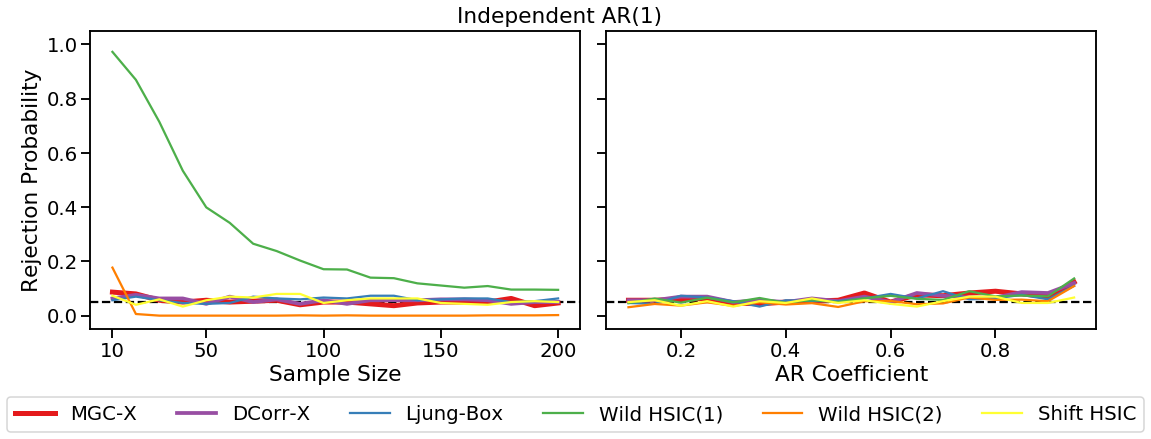

In [4]:
sns.set_context('talk', font_scale=1.2)
fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True, constrained_layout=True)

# plot varying N plot
df = load_power_curves(processes=["indep_ar1"])
tmp = df.melt(
    id_vars='n', 
    value_vars=['mgcx', 'dcorrx', 'ljungx', 'wildHSIC', 'wildHSIC2', 'shiftHSIC']
)
ax[0].axhline(y=0.05, ls="--", c="k")

sns.lineplot(
    data = tmp,
    x = 'n',
    y = 'value',
    hue = 'variable',
    ax = ax[0],
    palette=colors,
)

for line in ax[0].get_lines():
    if line.get_c() == "#e41a1c":
        line.set_linewidth(5)
    if line.get_c() == "#984ea3":
        line.set_linewidth(3.75)

handles, labels = ax[0].get_legend_handles_labels()
ax[0].get_legend().remove()
ax[0].set_xticks([10, 50, 100, 150, 200])
ax[0].set_ylabel("Rejection Probability")
ax[0].set_xlabel("Sample Size")

# plot varying AR plot
df = load_indep_ars()
tmp = df.melt(
        id_vars='ar_coeff', 
        value_vars=['MGC-X_powers', 'DCorr-X_powers', 
                    'LjungX_powers', 'wildHSIC_powers', 
                    'wildHSIC2_powers', 'shiftHSIC_powers']
    )
ax[1].axhline(y=0.05, ls="--", c="k")
sns.lineplot(data=tmp, x = 'ar_coeff', y='value', hue='variable', palette=color_dict2, ax=ax[1])
ax[1].set_ylim(-0.05, 1.05)
ax[1].set_xlabel("AR Coefficient")
ax[1].get_legend().remove()

for line in ax[1].get_lines():
    if line.get_c() == "#e41a1c":
        line.set_linewidth(5)
    if line.get_c() == "#984ea3":
        line.set_linewidth(3.75)

# Make title
fig.text(0.5, 1.03, "Independent AR(1)", va='center', ha='center')

# Deal with legends
handles, labels = ax[0].get_legend_handles_labels()

legend = fig.legend(
    handles[1:], 
    ['MGC-X', 'DCorr-X', 'Ljung-Box', 'Wild HSIC(1)', 'Wild HSIC(2)', 'Shift HSIC'],
    ncol = 7, 
    loc='lower center',
    bbox_to_anchor=(.515, -0.15),
    bbox_transform=plt.gcf().transFigure
)

fig.savefig("figure1.png", dpi=300, bbox_inches='tight')

# Figure 2

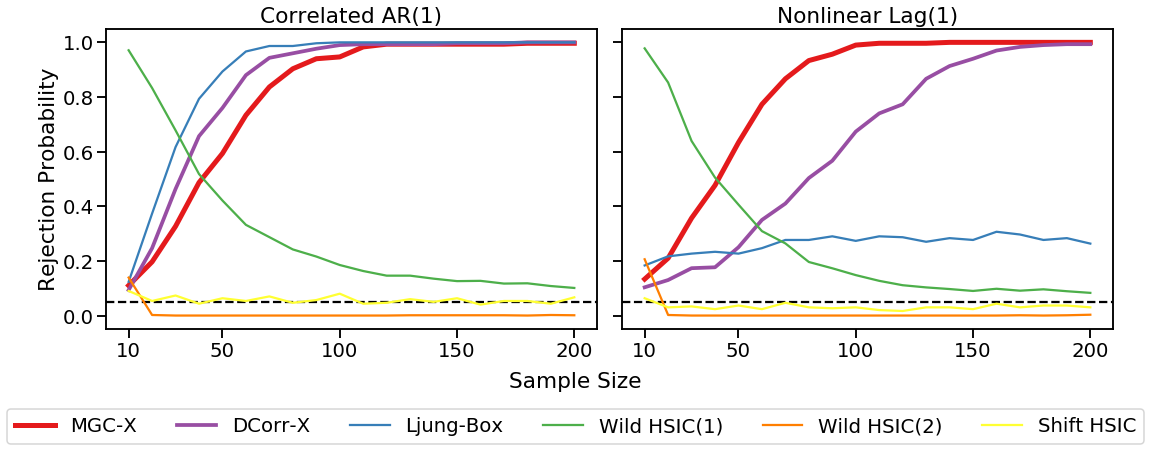

In [5]:
processes = ["corr_ar1", "nonlin_lag1"]
title_dict = dict(
    corr_ar1 = "Correlated AR(1)", 
    nonlin_lag1 = "Nonlinear Lag(1)"
)

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True, constrained_layout=True)

# plot varying N plot
df = load_power_curves(processes=processes)

for i, process in enumerate(processes):
    tmp = df[df.process==process].melt(
        id_vars='n', 
        value_vars=['mgcx', 'dcorrx', 'ljungx', 'wildHSIC', 'wildHSIC2', 'shiftHSIC']
    )
    ax[i].axhline(y=0.05, ls="--", c="k")
    sns.lineplot(
        data = tmp,
        x = 'n',
        y = 'value',
        hue = 'variable',
        ax = ax[i],
        palette = colors
    )
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].set_title(title_dict[process])

    handles, labels = ax[0].get_legend_handles_labels()
    ax[i].get_legend().remove()
    ax[i].set_xticks([10, 50, 100, 150, 200])
    ax[i].set_ylabel("Rejection Probability")
    
    for line in ax[i].get_lines():
        if line.get_c() == "#e41a1c":
            line.set_linewidth(5)
        if line.get_c() == "#984ea3":
            line.set_linewidth(3.75)

fig.text(0.5, -0.05, "Sample Size", va='center', ha='center')

# Deal with legends
handles, labels = ax[0].get_legend_handles_labels()
legend = fig.legend(
    handles[1:], 
    ['MGC-X', 'DCorr-X', 'Ljung-Box', 'Wild HSIC(1)', 'Wild HSIC(2)', 'Shift HSIC'],
    ncol = 7, 
    loc='lower center',
    bbox_to_anchor=(.5, -0.25),
    bbox_transform=plt.gcf().transFigure
)

fig.savefig("figure2.png", dpi=300, bbox_inches='tight')

# Figure 3

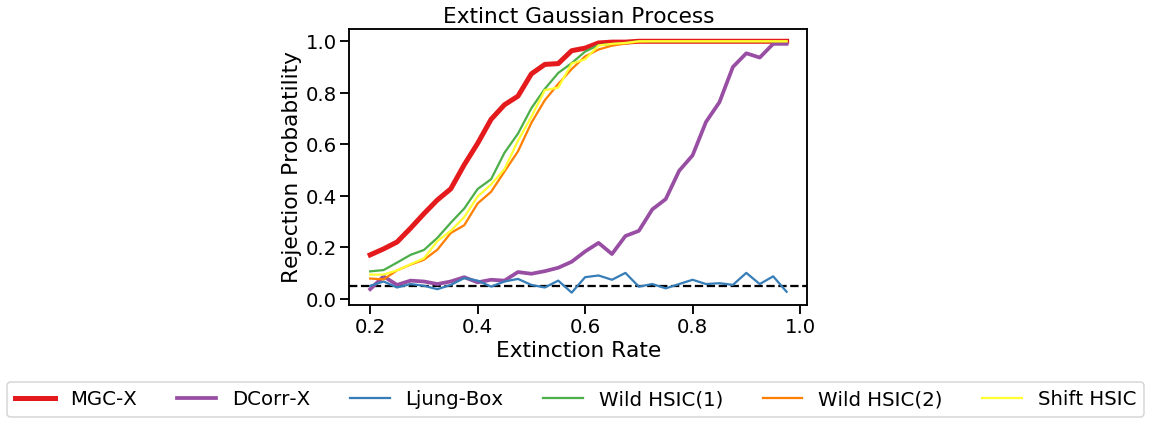

In [6]:
fig, ax = plt.subplots(ncols=1, figsize=(7.5, 5), constrained_layout=True)

df = load_extinct_gaussian()
tmp = df.melt(
        id_vars='extinction_rate', 
        value_vars=['MGC-X_powers', 'DCorr-X_powers', 
                    'LjungX_powers', 'wildHSIC_powers', 
                    'wildHSIC2_powers', 'shiftHSIC_powers']
    )
ax.axhline(y=0.05, ls="--", c="k")
sns.lineplot(data=tmp, x = 'extinction_rate', y='value', hue='variable', ax=ax, palette=colors)
ax.set_title("Extinct Gaussian Process")
ax.set_xlabel("Extinction Rate")
ax.set_ylabel("Rejection Probabtility")
ax.get_legend().remove()

for line in ax.get_lines():
    if line.get_c() == "#e41a1c":
        line.set_linewidth(5)
    if line.get_c() == "#984ea3":
            line.set_linewidth(3.75)

# Deal with legends
handles, labels = ax.get_legend_handles_labels()

# legend = fig.legend(
#     handles[1:], 
#     ['MGC-X', 'DCorr-X', 'Ljung-BoX', 'Wild HSIC(1)', 'Wild HSIC(2)', 'Shift HSIC'],
#     ncol = 1, 
#     loc='right',
#     bbox_to_anchor=(1.4, .5),
#     bbox_transform=plt.gcf().transFigure
# )
legend = fig.legend(
    handles[1:], 
    ['MGC-X', 'DCorr-X', 'Ljung-Box', 'Wild HSIC(1)', 'Wild HSIC(2)', 'Shift HSIC'],
    ncol = 7, 
    loc='lower center',
    bbox_to_anchor=(.55, -0.175),
    bbox_transform=plt.gcf().transFigure
)

fig.savefig("figure3.png", dpi=300, bbox_inches='tight')